In [2]:
import os
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.models import resnet18 # Puedes probar con otros modelos como efficientnet_b0
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset

In [3]:
## Configuring Routes and Parameters

In [4]:

# --- Path Configuration --- #
PATH_TO_VISUAL_DATA = "C:\\Users\\mgalicia\\CowsProyect\\visual_data\\visual_data"      
PATH_TO_CROPPED_BBOXES_ROOT = r"~/Downloads/cropped_bboxes"
PATH_TO_BEHAVIORS = os.path.join(PATH_TO_CROPPED_BBOXES_ROOT, 'behaviors')

# --- Step 2: Define Class Mapping --- #
# This mapping connects folder names to behavior labels.
behavior_mapping = {
    '1': 'Walking',
    '2': 'Standing',
    '3': 'Feeding head up',
    '4': 'Feeding head down',
    '5': 'Licking',
    '6': 'Drinking',
    '7': 'Lying'
}

# --- Training Parameters --- #
BATCH_SIZE = 32            # Can reduce to 16 if memory is limited
NUM_EPOCHS = 10            # Initial setting, can increase later
LEARNING_RATE = 0.001      # Typical learning rate
IMAGE_SIZE = (224, 224)    # Standard input size for pre-trained models like ResNet

# --- Device Configuration --- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f" Using device: {device}")


 Using device: cuda


In [5]:

# --- Step 3: Load Dataset using ImageFolder --- #
print(f"Loading dataset from: {PATH_TO_BEHAVIORS}")

try:
    # Load the dataset without transformations for now
    full_dataset = datasets.ImageFolder(root=PATH_TO_BEHAVIORS, transform=None)
except Exception as e:
    print(f"ERROR: Could not load dataset from {PATH_TO_BEHAVIORS}. Please check the path and folder structure.")
    print(f"Error details: {e}")
    exit()

# --- Step 3: Map Folder Names to Readable Behavior Labels --- #
# ImageFolder assigns class indices based on folder names (alphabetically).
# We need to map those indices to readable behavior names.

# Folder names as detected by ImageFolder (should be: ['1', '2', '3', '4', '5', '6', '7'])
imagefolder_class_names = [full_dataset.classes[i] for i in range(len(full_dataset.classes))]

# Map class indices to readable labels using behavior_mapping
class_names_readable = [behavior_mapping.get(c, f"Unknown_{c}") for c in imagefolder_class_names]
num_classes = len(class_names_readable)

# Display detected classes
print(f" Detected behavior folders (numbers): {imagefolder_class_names}")
print(f" Mapped behavior labels: {class_names_readable}")
print(f" Total number of images: {len(full_dataset)}")


Loading dataset from: ~/Downloads/cropped_bboxes/behaviors
 Detected behavior folders (numbers): ['1', '2', '3', '4', '5', '6', '7']
 Mapped behavior labels: ['Walking', 'Standing', 'Feeding head up', 'Feeding head down', 'Licking', 'Drinking', 'Lying']
 Total number of images: 213686


In [6]:

# --- Step: Define Image Transformations --- #

# Transformations for the training set (includes data augmentation)
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),          # Resize to 224x224
    transforms.RandomHorizontalFlip(),      # Random flip for data augmentation
    transforms.RandomRotation(10),          # Random rotation for augmentation
    transforms.ToTensor(),                  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

# Transformations for validation and test sets (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [7]:

# --- Step 1: Prepare Train/Validation/Test Splits --- #

# Get the class labels (targets) assigned by ImageFolder
targets = full_dataset.targets

# Calculate dataset sizes
train_size = int(0.7 * len(full_dataset))  # 70% training
val_size = int(0.15 * len(full_dataset))   # 15% validation
test_size = len(full_dataset) - train_size - val_size  # Remaining for testing

# First split: Train vs Test
train_idx, test_idx, _, _ = train_test_split(
    range(len(full_dataset)), targets, test_size=test_size, stratify=targets, random_state=42
)

# Second split: Train vs Validation
train_idx, val_idx, _, _ = train_test_split(
    train_idx, [targets[i] for i in train_idx], test_size=val_size / (train_size + val_size),
    stratify=[targets[i] for i in train_idx], random_state=42
)

# --- Step 2: Create Dataset Subsets --- #

# Create PyTorch subsets using the selected indices
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# --- Step 3: Apply Transformations --- #

# Apply transformations to each dataset
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# --- Step 4: Create DataLoaders --- #

# DataLoaders allow loading data in batches during training
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count() // 2)

# --- Step 5: Quick Check --- #
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 149580
Validation set size: 32052
Test set size: 32054


In [8]:
# --- Model Definition --- #
# Load a ResNet18 pre-trained on ImageNet
model = resnet18(weights='IMAGENET1K_V1')

# Replace the final fully connected layer to match the number of behavior classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the selected device (GPU or CPU)
model = model.to(device)

print("CNN model (ResNet18) defined successfully.")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/exouser/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 313MB/s]


CNN model (ResNet18) defined successfully.


In [9]:
# --- Loss Function --- #
# CrossEntropyLoss is used for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# --- Optimizer --- #
# Adam optimizer is widely used and works well in most cases
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Loss function and optimizer are set.")


Loss function and optimizer are set.


In [10]:

# --- Training Function --- #
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=NUM_EPOCHS):
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        # --- Training Step --- #
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update model weights

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_train / total_train
        print(f"Epoch {epoch+1} - Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.4f}")

        # --- Validation Step --- #
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient calculation
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_accuracy = correct_val / total_val
        print(f"Epoch {epoch+1} - Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

        # --- Save the Best Model --- #
        if val_epoch_accuracy > best_accuracy:
            best_accuracy = val_epoch_accuracy
            torch.save(model.state_dict(), 'best_cow_behavior_classifier.pth')
            print(f"✔️ Model saved: Best validation accuracy {best_accuracy:.4f}")

    print("🏁 Training completed successfully.")
    return model

# --- Start Training --- #
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader)


Epoch 1/10 [Train]: 100%|██████████| 4675/4675 [02:02<00:00, 38.25it/s]


Epoch 1 - Train Loss: 0.3532, Train Accuracy: 0.8744


Epoch 1/10 [Validation]: 100%|██████████| 1002/1002 [00:25<00:00, 39.12it/s]


Epoch 1 - Validation Loss: 0.2939, Validation Accuracy: 0.8980
✔️ Model saved: Best validation accuracy 0.8980


Epoch 2/10 [Train]: 100%|██████████| 4675/4675 [02:09<00:00, 36.22it/s]


Epoch 2 - Train Loss: 0.2591, Train Accuracy: 0.9066


Epoch 2/10 [Validation]: 100%|██████████| 1002/1002 [00:25<00:00, 38.79it/s]


Epoch 2 - Validation Loss: 0.2508, Validation Accuracy: 0.9084
✔️ Model saved: Best validation accuracy 0.9084


Epoch 3/10 [Train]: 100%|██████████| 4675/4675 [02:13<00:00, 35.08it/s]


Epoch 3 - Train Loss: 0.2170, Train Accuracy: 0.9204


Epoch 3/10 [Validation]: 100%|██████████| 1002/1002 [00:27<00:00, 37.08it/s]


Epoch 3 - Validation Loss: 0.2274, Validation Accuracy: 0.9188
✔️ Model saved: Best validation accuracy 0.9188


Epoch 4/10 [Train]: 100%|██████████| 4675/4675 [02:02<00:00, 38.13it/s]


Epoch 4 - Train Loss: 0.1769, Train Accuracy: 0.9336


Epoch 4/10 [Validation]: 100%|██████████| 1002/1002 [00:25<00:00, 39.26it/s]


Epoch 4 - Validation Loss: 0.2220, Validation Accuracy: 0.9219
✔️ Model saved: Best validation accuracy 0.9219


Epoch 5/10 [Train]: 100%|██████████| 4675/4675 [01:58<00:00, 39.55it/s]


Epoch 5 - Train Loss: 0.1371, Train Accuracy: 0.9474


Epoch 5/10 [Validation]: 100%|██████████| 1002/1002 [00:24<00:00, 40.45it/s]


Epoch 5 - Validation Loss: 0.2463, Validation Accuracy: 0.9154


Epoch 6/10 [Train]: 100%|██████████| 4675/4675 [02:05<00:00, 37.17it/s]


Epoch 6 - Train Loss: 0.0961, Train Accuracy: 0.9633


Epoch 6/10 [Validation]: 100%|██████████| 1002/1002 [00:27<00:00, 36.22it/s]


Epoch 6 - Validation Loss: 0.2844, Validation Accuracy: 0.9173


Epoch 7/10 [Train]: 100%|██████████| 4675/4675 [02:10<00:00, 35.82it/s]


Epoch 7 - Train Loss: 0.0691, Train Accuracy: 0.9739


Epoch 7/10 [Validation]: 100%|██████████| 1002/1002 [00:26<00:00, 37.15it/s]


Epoch 7 - Validation Loss: 0.3001, Validation Accuracy: 0.9159


Epoch 8/10 [Train]: 100%|██████████| 4675/4675 [01:58<00:00, 39.45it/s]


Epoch 8 - Train Loss: 0.0542, Train Accuracy: 0.9798


Epoch 8/10 [Validation]: 100%|██████████| 1002/1002 [00:25<00:00, 39.69it/s]


Epoch 8 - Validation Loss: 0.3429, Validation Accuracy: 0.9162


Epoch 9/10 [Train]: 100%|██████████| 4675/4675 [02:09<00:00, 36.07it/s]


Epoch 9 - Train Loss: 0.0428, Train Accuracy: 0.9841


Epoch 9/10 [Validation]: 100%|██████████| 1002/1002 [00:32<00:00, 31.25it/s]


Epoch 9 - Validation Loss: 0.3786, Validation Accuracy: 0.9215


Epoch 10/10 [Train]: 100%|██████████| 4675/4675 [02:13<00:00, 34.90it/s]


Epoch 10 - Train Loss: 0.0371, Train Accuracy: 0.9869


Epoch 10/10 [Validation]: 100%|██████████| 1002/1002 [00:29<00:00, 34.40it/s]

Epoch 10 - Validation Loss: 0.4246, Validation Accuracy: 0.9208
🏁 Training completed successfully.


Evaluating on Test Set: 100%|██████████| 1002/1002 [00:25<00:00, 39.29it/s]


✔️ Test Set Accuracy: 0.9197

📄 Classification Report:
                   precision    recall  f1-score   support

          Walking       0.46      0.16      0.23       618
         Standing       0.93      0.96      0.94     10516
  Feeding head up       0.80      0.68      0.73      2862
Feeding head down       0.81      0.89      0.85      4689
          Licking       0.90      0.90      0.90       301
         Drinking       0.71      0.74      0.73       497
            Lying       1.00      1.00      1.00     12571

         accuracy                           0.92     32054
        macro avg       0.80      0.76      0.77     32054
     weighted avg       0.91      0.92      0.91     32054



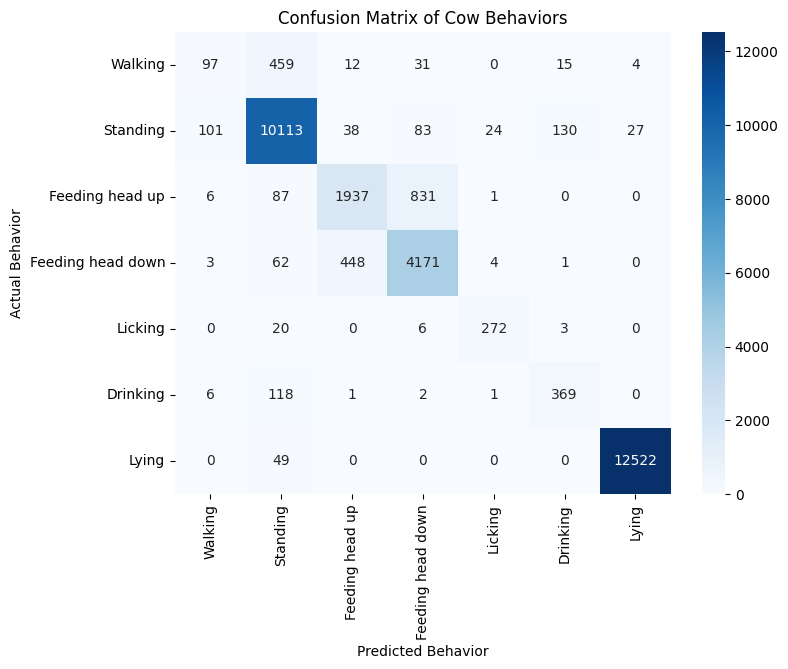

In [11]:
# --- Final Evaluation Function --- #
def evaluate_model(model, test_loader, class_names):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradient computation during evaluation
        for inputs, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate overall accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"✔️ Test Set Accuracy: {accuracy:.4f}")

    # Print detailed classification report
    print("\n📄 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix of Cow Behaviors')
    plt.xlabel('Predicted Behavior')
    plt.ylabel('Actual Behavior')
    plt.show()

# --- Run Final Evaluation --- #
evaluate_model(trained_model, test_loader, class_names_readable) 
